## 广东2022年7月清洁与污染个例
## `GZ_2207 Clean & Pollute`

---
*@author: Evan*\
*@date: 2022-08-29*

In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime

import scipy.io as io

In [2]:
# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 允许显示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

## 读取数据

In [4]:
GridFile=nc.Dataset('F:/Data/caseGZ_2207/GRIDCRO2D_2022200.nc')
chemFile=nc.Dataset('F:/Data/caseGZ_2207/COMBINE_ACONC_CN3GD_152X110_202207_mech.nc')
uvFile=nc.Dataset('F:/Data/caseGZ_2207/COMBINE_ACONC_CN3GD_152X110_202207_uv_vertical.nc')
print('variables in GridFile',GridFile.variables.keys())
print('variables in chemFile',chemFile.variables.keys())

variables in GridFile dict_keys(['TFLAG', 'LAT', 'LON', 'MSFX2', 'HT', 'DLUSE', 'LWMASK', 'PURB'])
variables in chemFile dict_keys(['TFLAG', 'WWind', 'ZH', 'CO', 'O3', 'NO', 'NO2', 'VOC'])


In [5]:
GridFile.variables['HT'].shape

(1, 1, 110, 152)

In [6]:
chemFile.variables['ZH'].shape

(456, 38, 110, 152)

In [7]:
lat=np.squeeze(GridFile.variables['LAT'][:,:,46:76,74])
lon=np.squeeze(GridFile.variables['LON'][:,:,58,64:96])
HT_h=np.squeeze(GridFile.variables['HT'][:,:,58,64:96]) # 地形高度
HT_v=np.squeeze(GridFile.variables['HT'][:,:,46:76,74])
NO2_h=np.squeeze(chemFile.variables['NO2'][120:,:,58,64:96])*47/22.4 # lat=23.18
NO2_v=np.squeeze(chemFile.variables['NO2'][120:,:,46:76,74])*47/22.4 # lon=113.3
wwind_h=np.squeeze(chemFile.variables['WWind'][120:,:,58,64:96])
wwind_v=np.squeeze(chemFile.variables['WWind'][120:,:,46:76,74])
uwind=np.squeeze(uvFile.variables['UWind'][120:456,:,58,64:96])
vwind=np.squeeze(uvFile.variables['VWind'][120:456,:,46:76,74])
ZH_h=np.squeeze(chemFile.variables['ZH'][0,:,58,64:96]) # 不同层的地上高度
ZH_v=np.squeeze(chemFile.variables['ZH'][0,:,46:76,74])

lonu=np.tile(lon,(38,1))
latu=np.tile(lat,(38,1))

print('lat   = ',latu.shape)
print('lon   = ',lonu.shape)
print('NO2_h  = ',NO2_h.shape)
print('NO2_v  = ',NO2_v.shape)
print('uwind = ',uwind.shape)
print('vwind = ',vwind.shape)
print('wwind_h = ',wwind_h.shape)
print('wwind_v = ',wwind_v.shape)
print('ZH_h  =',ZH_h.shape)
print('ZH_v  =',ZH_v.shape)
print('HT_h  =',HT_h.shape)
print('HT_v  =',HT_v.shape)

lat   =  (38, 30)
lon   =  (38, 32)
NO2_h  =  (336, 38, 32)
NO2_v  =  (336, 38, 30)
uwind =  (336, 38, 32)
vwind =  (336, 38, 30)
wwind_h =  (336, 38, 32)
wwind_v =  (336, 38, 30)
ZH_h  = (38, 32)
ZH_v  = (38, 30)
HT_h  = (32,)
HT_v  = (30,)


In [8]:
# 将地形高度与各层离地高度相加，获得各层的绝对高度
ht_h=np.zeros([38,32])
ht_v=np.zeros([38,30])
for i in range(38):
    ht_h[i,:]=ZH_h[i,:]+HT_h
    ht_v[i,:]=ZH_v[i,:]+HT_v

print(ht_h.shape)

(38, 32)


In [9]:
def t2step(date: 'int',hour: 'int',start_date: 'int',end_date: 'int'):
    """
    convert time point wanted to time step in model data
    """
    delt=date-start_date-1
    tstep=delt*24+16+hour
    return(tstep)

## 绘图

### 1.单幅图

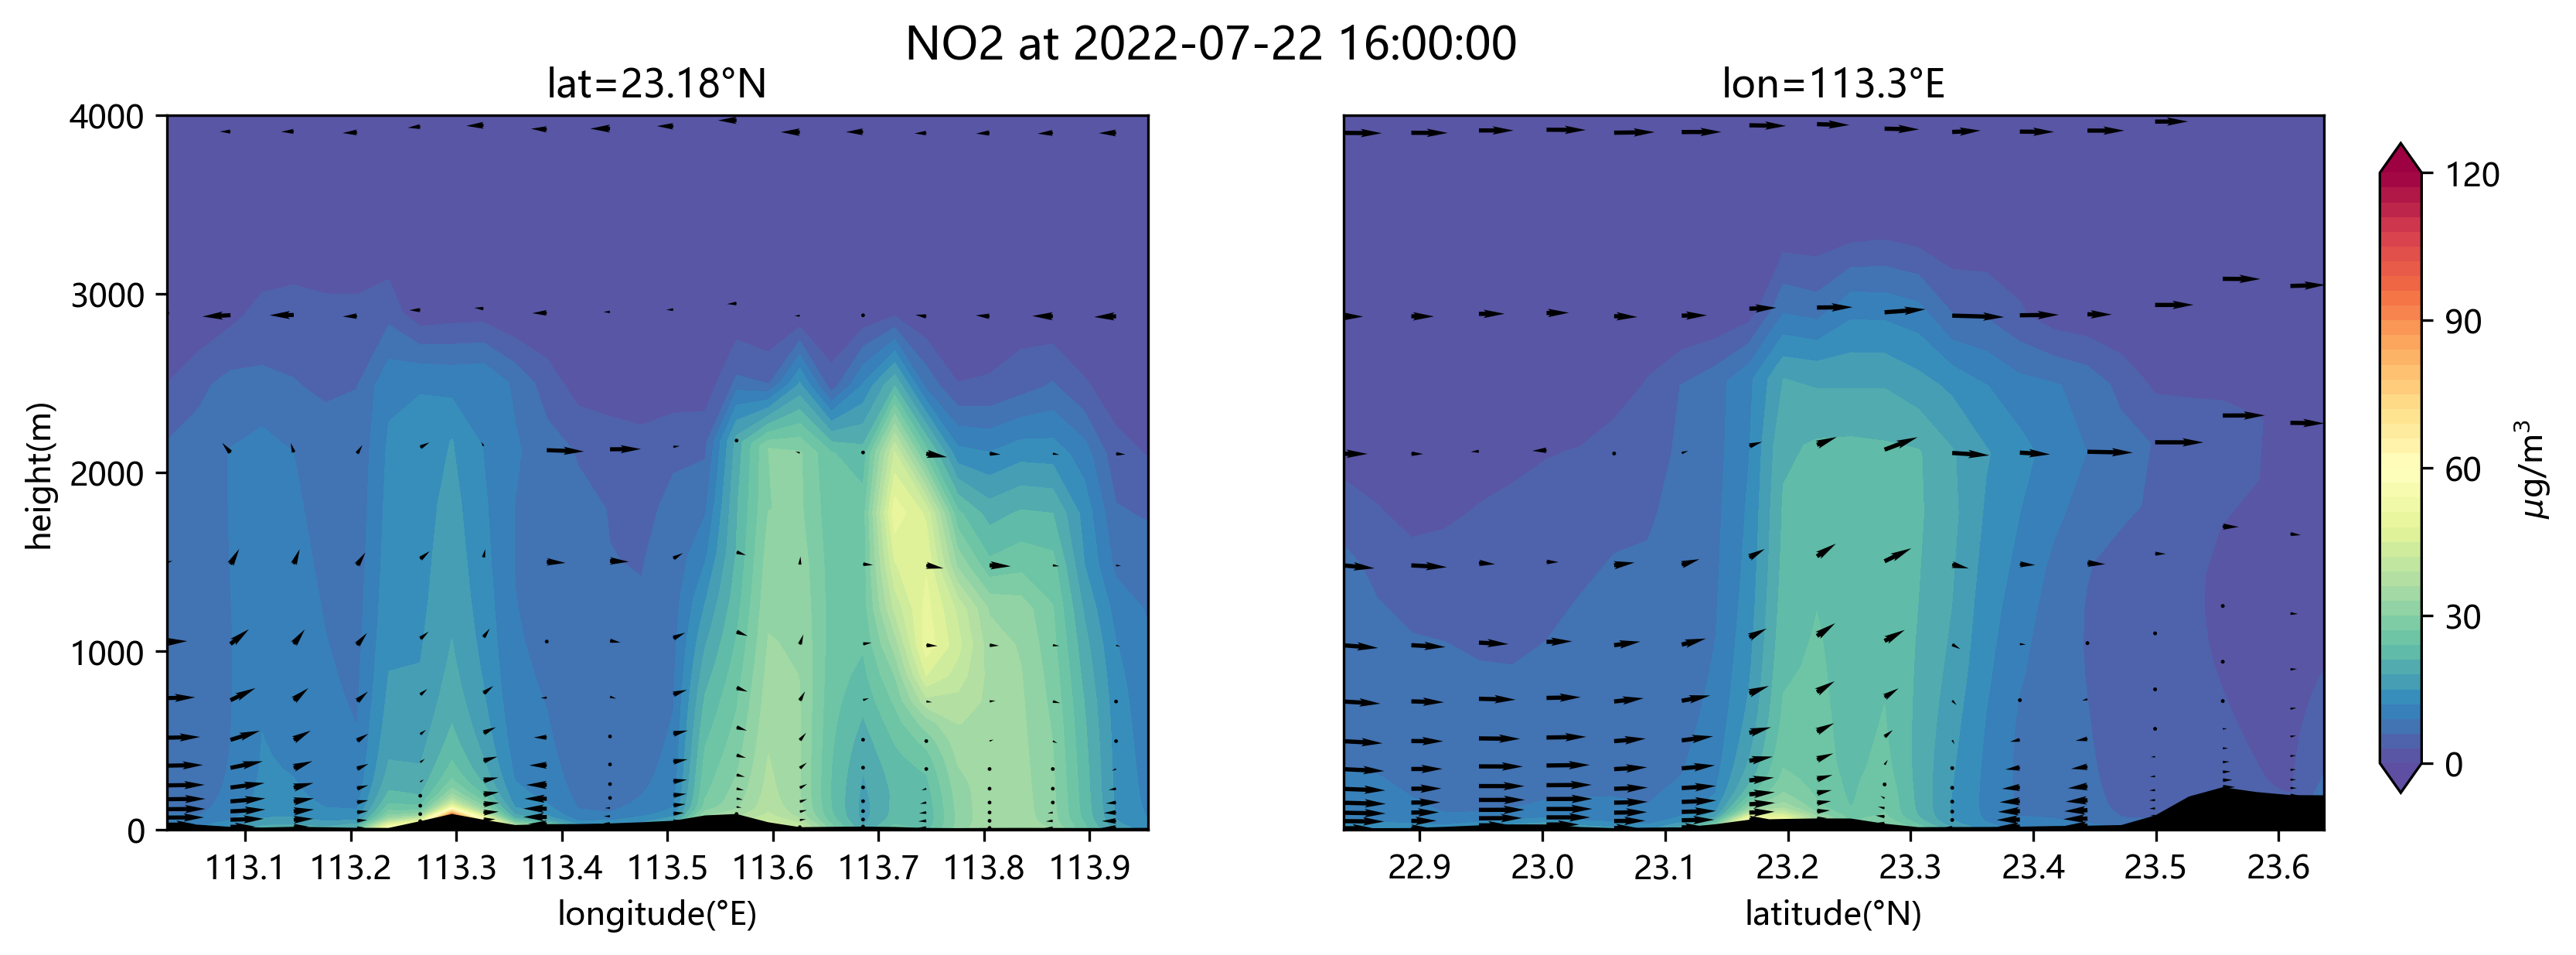

In [11]:
date=22
hour=16
tstep=t2step(date,hour,15,28)
nlevel=26 # set height level

cmax=121
cmaplevel=np.arange(0,cmax,3)

fig = plt.figure(figsize=(12,4),dpi=300)
ax = fig.subplots(1,2)

# ---------------ax[0]:lat=23.18----------------

# contour map
cmap=ax[0].contourf(lonu.T[:,0:nlevel],ht_h.T[:,0:nlevel],NO2_h[tstep,0:nlevel,:].T,cmap='Spectral_r',levels=cmaplevel,extend='both')

# fillbetween
ax[0].fill_between(lonu.T[:,0],0,ht_h.T[:,0],where=ht_h.T[:,0]>0,facecolor='k')

# set label and ticks
ax[0].set_xlabel('longitude(°E)')
ax[0].set_xticks(np.arange(113,114,0.1))
ax[0].set_ylabel('height(m)')
ax[0].set_yticks(np.arange(0,4001,1000))
ax[0].set_ylim(0,4001)

# wind quiver
xgrid=np.size(lonu,1)
ygrid=np.size(ht_h,0)
ngrid=2

ax[0].quiver(lonu[0:nlevel:ngrid,0:xgrid:ngrid],ht_h[0:nlevel:ngrid,0:xgrid:ngrid],
        uwind[tstep,0:nlevel:ngrid,0:xgrid:ngrid],wwind_h[tstep,0:nlevel:ngrid,0:xgrid:ngrid],
        color='k',alpha=1,scale=100,headwidth=2)

# ---------------ax[1]:lon=113.3----------------

# contour map
cmap=ax[1].contourf(latu.T[:,0:nlevel],ht_v.T[:,0:nlevel],NO2_v[tstep,0:nlevel,:].T,cmap='Spectral_r',levels=cmaplevel,extend='both')

# fillbetween
ax[1].fill_between(latu.T[:,0],0,ht_v.T[:,0],where=ht_v.T[:,0]>0,facecolor='k')

# set label and ticks
ax[1].set_xlabel('latitude(°N)')
ax[1].set_xticks(np.arange(22.8,23.7,0.1))
ax[1].set_yticks([])
ax[1].set_ylim(0,4001)

# wind quiver
ax[1].quiver(latu[0:nlevel:ngrid,0:xgrid:ngrid],ht_v[0:nlevel:ngrid,0:xgrid:ngrid],
        vwind[tstep,0:nlevel:ngrid,0:xgrid:ngrid],wwind_v[tstep,0:nlevel:ngrid,0:xgrid:ngrid],
        color='k',alpha=1,scale=100,headwidth=2)


# share colorbar
fig.subplots_adjust(right=0.9)
position= fig.add_axes([0.92,0.15,0.015,0.7])
cbar=fig.colorbar(cmap,cax=position)
cbar.set_ticks(np.arange(0,cmax+1,30))
cbar.set_label('$\mu$g/m$^3$')

# set titles
ax[0].set_title('lat=23.18°N')
ax[1].set_title('lon=113.3°E')
plt.suptitle('NO2 at '+str(datetime.datetime(2022,7,date,hour)),size=14)
plt.show()

### 2.多图

In [12]:
date=np.arange(15,29,1)
hour=np.arange(0,24,1)
for i in range(np.size(date)):
    for j in range(np.size(hour)):
        tstep=t2step(date[i],hour[j],15,28)
        nlevel=26 # set height level

        cmax=121
        cmaplevel=np.arange(0,cmax,3)

        fig = plt.figure(figsize=(12,4),dpi=300)
        ax = fig.subplots(1,2)

        # ---------------ax[0]:lat=23.18----------------

        # contour map
        cmap=ax[0].contourf(lonu.T[:,0:nlevel],ht_h.T[:,0:nlevel],NO2_h[tstep,0:nlevel,:].T,cmap='Spectral_r',levels=cmaplevel,extend='both')

        # fillbetween
        ax[0].fill_between(lonu.T[:,0],0,ht_h.T[:,0],where=ht_h.T[:,0]>0,facecolor='k')

        # set label and ticks
        ax[0].set_xlabel('longitude(°E)')
        ax[0].set_xticks(np.arange(113,114,0.1))
        ax[0].set_ylabel('height(m)')
        ax[0].set_yticks(np.arange(0,4001,1000))
        ax[0].set_ylim(0,4001)

        # wind quiver
        xgrid=np.size(lonu,1)
        ygrid=np.size(ht_h,0)
        ngrid=2

        ax[0].quiver(lonu[0:nlevel:ngrid,0:xgrid:ngrid],ht_h[0:nlevel:ngrid,0:xgrid:ngrid],
                uwind[tstep,0:nlevel:ngrid,0:xgrid:ngrid],wwind_h[tstep,0:nlevel:ngrid,0:xgrid:ngrid],
                color='k',alpha=1,scale=100,headwidth=2)

        # ---------------ax[1]:lon=113.3----------------

        # contour map
        cmap=ax[1].contourf(latu.T[:,0:nlevel],ht_v.T[:,0:nlevel],NO2_v[tstep,0:nlevel,:].T,cmap='Spectral_r',levels=cmaplevel,extend='both')

        # fillbetween
        ax[1].fill_between(latu.T[:,0],0,ht_v.T[:,0],where=ht_v.T[:,0]>0,facecolor='k')

        # set label and ticks
        ax[1].set_xlabel('latitude(°N)')
        ax[1].set_xticks(np.arange(22.8,23.7,0.1))
        ax[1].set_yticks([])
        ax[1].set_ylim(0,4001)

        # wind quiver
        ax[1].quiver(latu[0:nlevel:ngrid,0:xgrid:ngrid],ht_v[0:nlevel:ngrid,0:xgrid:ngrid],
                vwind[tstep,0:nlevel:ngrid,0:xgrid:ngrid],wwind_v[tstep,0:nlevel:ngrid,0:xgrid:ngrid],
                color='k',alpha=1,scale=100,headwidth=2)

        # share colorbar
        fig.subplots_adjust(right=0.9)
        position= fig.add_axes([0.92,0.15,0.015,0.7])
        cbar=fig.colorbar(cmap,cax=position)
        cbar.set_ticks(np.arange(0,cmax+1,30))
        cbar.set_label('$\mu$g/m$^3$')

        # set titles
        ax[0].set_title('lat=23.18°N')
        ax[1].set_title('lon=113.3°E')
        plt.suptitle('NO2 at '+str(datetime.datetime(2022,7,date[i],hour[j])),size=14)

        figure_path='F:/Data/caseGZ_2207/Figure/NO2_ver/'
        plt.savefig(figure_path+str(datetime.date(2022,7,date[i]))+'_'+str(hour[j]).zfill(2)+'.png')
        print('Now printing '+str(datetime.datetime(2022,7,date[i],hour[j])))
print('Printing Completed!')
# plt.show()

Now printing 2022-07-15 00:00:00
Now printing 2022-07-15 01:00:00
Now printing 2022-07-15 02:00:00
Now printing 2022-07-15 03:00:00
Now printing 2022-07-15 04:00:00
Now printing 2022-07-15 05:00:00
Now printing 2022-07-15 06:00:00
Now printing 2022-07-15 07:00:00
Now printing 2022-07-15 08:00:00
Now printing 2022-07-15 09:00:00
Now printing 2022-07-15 10:00:00
Now printing 2022-07-15 11:00:00
Now printing 2022-07-15 12:00:00
Now printing 2022-07-15 13:00:00
Now printing 2022-07-15 14:00:00
Now printing 2022-07-15 15:00:00
Now printing 2022-07-15 16:00:00
Now printing 2022-07-15 17:00:00
Now printing 2022-07-15 18:00:00
Now printing 2022-07-15 19:00:00
Now printing 2022-07-15 20:00:00
Now printing 2022-07-15 21:00:00
Now printing 2022-07-15 22:00:00
Now printing 2022-07-15 23:00:00
Now printing 2022-07-16 00:00:00
Now printing 2022-07-16 01:00:00
Now printing 2022-07-16 02:00:00
Now printing 2022-07-16 03:00:00
Now printing 2022-07-16 04:00:00
Now printing 2022-07-16 05:00:00
Now printi